Using CasJobs to query SDSS data

In [3]:
import SciServer
from SciServer import Authentication, LoginPortal, Config, CasJobs, SkyQuery, SciDrive, SkyServer, Files, Jobs
import os;
import pandas;
import sys;
import json;
from io import StringIO
from io import BytesIO
#from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define login Name and password before running these examples
Authentication_loginName = 'snegussie'
Authentication_loginPassword = 'kokjed-4sogvy-bIhxyd'

Authentication_login_sharedWithName = '***'
Authentication_login_sharedWithPassword = '***'

#getting token
token1 = Authentication.login(Authentication_loginName, Authentication_loginPassword)
print("token1 = " + token1)
user = Authentication.getKeystoneUserWithToken(token1)
iden = Authentication.identArgIdentifier()
print("userName = ", user.userName, "id = ", user.id, "ident = ", iden)


token1 = 1c35ddee220c443a9bd55b3948dc1b98
userName =  snegussie id =  3bd62d3d73654e318ecd7c375a40e27e ident =  --ident=


In [7]:
#Defining databse context and query, and other variables
CasJobs_TestDatabase = "MyDB"
CasJobs_TestQuery = "select 4 as Column1, 5 as Column2 "
CasJobs_TestTableName1 = "MyNewtable1"
CasJobs_TestTableName2 = "MyNewtable2"
CasJobs_TestTableCSV = u"Column1,Column2\n4,5\n"
CasJobs_TestFitsFile = "SciScriptTestFile.fits"
CasJobs_TestCSVFile = "SciScriptTestFile.csv"

#get user schema info
casJobsId = CasJobs.getSchemaName()
print(casJobsId)

#get info about tables inside MyDB database context:
tables = CasJobs.getTables(context="MyDB")
print(tables)

#execute a quick SQL query:
df = CasJobs.executeQuery(sql=CasJobs_TestQuery, context=CasJobs_TestDatabase, format="pandas")
print(df)


wsid_1864490916
[{'Name': 'QuickResults', 'Rows': 2, 'Size': 136, 'Date': 637940143472400000}]
   Column1  Column2
0        4        5


In [8]:
#submit a job, which inserts the query results into a table in the MyDB database context. 
#Wait until the job is done and get its status.
jobId = CasJobs.submitJob(sql=CasJobs_TestQuery + " into MyDB." + CasJobs_TestTableName1, context="MyDB")
jobDescription = CasJobs.waitForJob(jobId=jobId, verbose=False)
print(jobId)
print(jobDescription)

56195932
{'JobID': 56195932, 'Rows': 1, 'WebServicesID': 1864490916, 'TimeSubmit': '2022-07-22T12:58:59.967', 'TimeStart': '2022-07-22T12:59:05.29', 'TimeEnd': '2022-07-22T12:59:05.367', 'SendEmail': 0, 'Status': 5, 'AutoComplete': 0, 'Estimate': 500, 'TaskName': 'SciScript-Python.CasJobs.submitJob', 'OutputLoc': '', 'HostIP': 'SQL001DBHost   ', 'Message': 'Query Complete', 'Query': 'select 4 as Column1, 5 as Column2  into MyDB.MyNewtable1', 'ModifiedQuery': 'select 4 as Column1, 5 as Column2  /*CASJOBS_INTO_TABLE:[mydbsql].mydb_1864490916.webuser.MyNewtable1*/', 'Target': 'MyDB', 'OutputType': 'QUERY', 'Params': '{\r\n  "token": "1c35ddee220c443a9bd55b3948dc1b98"\r\n}', 'Created_Table': 'MyNewtable1'}


In [10]:
#execute a query and write a local Fits file containing the query results:
result = CasJobs.writeFitsFileFromQuery(fileName=CasJobs_TestFitsFile, queryString=CasJobs_TestQuery, context="MyDB")
print(result)

#get a Pandas dataframe containing the results of a query
df = CasJobs.getPandasDataFrameFromQuery(queryString=CasJobs_TestQuery, context=CasJobs_TestDatabase)
print(df)

True
   Column1  Column2
0        4        5


Here is to get an image


In [13]:
#defining sql query and SDSS data relelease:
SkyServer_TestQuery = "select top 1 specobjid, ra, dec from specobj order by specobjid"
SkyServer_DataRelease = "DR17"

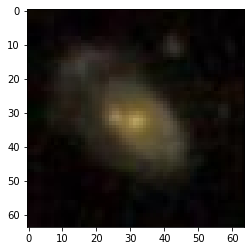

In [31]:
#get an image cutout

img = SkyServer.getJpegImgCutout(ra=179.689293, dec=-0.454379, width=2, height=2, scale=0.4, 
                                 dataRelease=SkyServer_DataRelease,#opt="OG", 
                                 query= "ObjType: S")
plt.imshow(img)

In [19]:
# do a radial search of objects:
#arcmins

df = SkyServer.radialSearch(ra=258.25, dec=64.05, radius=0.1, dataRelease=SkyServer_DataRelease)
print(df)

                 objid   run  rerun  camcol  field  obj  type          ra  \
0  1237671939804561654  6162    301       3    133  246     3  258.250804   

         dec         u        g         r         i         z     Err_u  \
0  64.051445  23.33982  22.3194  21.41105  21.11971  20.84277  0.664019   

      Err_g    Err_r     Err_i     Err_z  
0  0.116986  0.07641  0.080523  0.238198  


In [22]:
help(SciServer)

Help on package SciServer:

NAME
    SciServer

DESCRIPTION
    This python package provides functions for quick access of SciServer APIs (web services) and tools.
    SciServer (http://www.sciserver.org) provides a new online framework for data-intensive scientifc computing in the cloud,
    where the motto is to bring the computation close where the data is stored, and allow seamless access and sharing of big data sets within the scientific community.
    
    Some SciServer tools you can access with this package:
    
    
    * `Login Portal <https://portal.sciserver.org>`_: Single sign-on portal to all SciServer applications.
                    Although some tools accept anonymous access, you can use Authentication.login to login and access the tools and your own data and environment (after registering in the Login Portal). If you are running this package in a Jupyter Notebook in the SciServer-Compute environment, the use of Authentication.login is not necessary since it's done a

In [25]:
bigtablename = 'hugetable'

# Example of a longer query: get magnitudes and sizes (Petrosian radii) of one million galaxies
verylongquery = 'ra=179.689293, dec=-0.454379 \n'
verylongquery += 'u, g, r, i, z, err_u, err_g, err_r, err_i, err_z, petror90_r \n'
verylongquery += 'into mydb.' + bigtablename + '\n'
verylongquery += 'from galaxy\n'
verylongquery += 'where clean = 1'

print('Submitting query:\n',verylongquery)
print('\n')

thisjobid = CasJobs.submitJob(sql=verylongquery, context="DR14")

print('Job submitted with jobId = ',thisjobid)
print('\n')

waited = CasJobs.waitForJob(jobId=thisjobid)      # waited is a dummy variable; just print wait msg
jobDescription = CasJobs.getJobStatus(thisjobid)

print('\n')
print('Information about the job:')

#pprint(jobDescription)
#jobDescriber(jobDescription)

Submitting query:
 ra=179.689293, dec=-0.454379 
u, g, r, i, z, err_u, err_g, err_r, err_i, err_z, petror90_r 
into mydb.hugetable
from galaxy
where clean = 1




Exception: Error when submitting a job. Http Response from CasJobs API returned status code 401:
{"Error Code":401,"Error Type":"Unauthorized","Error Message":"Authentication failed: Response status code does not indicate success: 500 ().","LogMessageID":"25a08fb3-75f8-4420-9f65-ab92705c5f31"}